<Axes: >

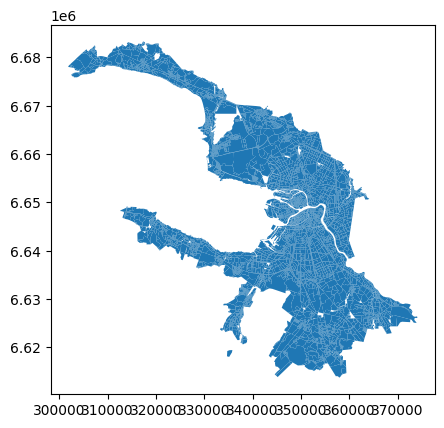

In [1]:
import geopandas as gpd
import osmnx as ox

blocks_gdf = gpd.read_parquet('./data/blocks.parquet')
query = 'Санкт Петербург, Васильевский остров'
mask_gdf = ox.features_from_place(query, tags={'boundary':'administrative'}).to_crs(blocks_gdf.crs)
# blocks_gdf = blocks_gdf[blocks_gdf.intersects(mask_gdf.unary_union)]
blocks_gdf.plot()

In [ ]:
import shapely
import pandas as pd
import pandera as pa
import geopandas as gpd
import networkx as nx
import pickle
from itertools import combinations
from tqdm import tqdm
from loguru import logger
from pandera.typing import Series
from longsgis import voronoiDiagram4plg
from ..models.land_use import LandUse
from ..models.schema import BaseSchema

SOURCE_COLUMN = 'source'
TARGET_COLUMN = 'target'

ADJACENCY_BUFFER = 1_000
INTERSECTION_BUFFER = 1

tqdm.pandas()

class BlocksSchema(BaseSchema):
    _geom_types = [shapely.Polygon]
    land_use : Series = pa.Field(isin=LandUse, nullable=True)
            
    @pa.parser('land_use')
    @classmethod
    def parse_land_use(cls, series : pd.Series):

        def parse(lu):
            if isinstance(lu, str):
                return LandUse[lu.lower()]
            return lu

        return series.apply(parse)
    
def _generate_voronoi(blocks_gdf : gpd.GeoDataFrame, buffer_size : int):
    logger.info('Generating voronoi diagram')
    mask = blocks_gdf.buffer(buffer_size).unary_union
    points = {shapely.Point(coord) for block_geom in blocks_gdf.geometry for coord in block_geom.exterior.coords}
    voronoi_polygons = shapely.voronoi_polygons(shapely.MultiPoint(list(points)), extend_to=mask)
    voronoi_gdf = gpd.GeoDataFrame(geometry=list(voronoi_polygons.geoms), crs=blocks_gdf.crs)
    return voronoi_gdf.clip(mask)

def _generate_grid(blocks_gdf : gpd.GeoDataFrame, voronoi_gdf : gpd.GeoDataFrame):
    logger.info('Generating voronoi grid')
    gdfs = [blocks_gdf, voronoi_gdf]
    lines_list = [shapely.LineString(g.exterior) for gdf in gdfs for g in gdf.geometry]
    lines_union = shapely.unary_union(lines_list)
    geom_collection = shapely.polygonize([line for line in lines_union.geoms])
    return gpd.GeoDataFrame(geometry=list(geom_collection.geoms), crs=blocks_gdf.crs)

def _generate_adjacency_edges(blocks_gdf : gpd.GeoDataFrame, adjacency_buffer : int, intersection_buffer : int) -> set[tuple]:
    logger.info('Generating edges')
    blocks_gdf = blocks_gdf.copy()

    voronoi_gdf = _generate_voronoi(blocks_gdf, adjacency_buffer)
    grid_gdf = _generate_grid(blocks_gdf, voronoi_gdf)
    
    blocks_gdf['block_index'] = blocks_gdf.index
    blocks_gdf.geometry = blocks_gdf.buffer(INTERSECTION_BUFFER)
    sjoin_gdf = blocks_gdf.sjoin(grid_gdf).groupby('index_right').agg({'block_index': lambda s : set(sorted(s))})
    return {combination for s in sjoin_gdf.block_index for combination in combinations(s, 2)}

def generate_adjacency_graph(blocks_gdf : gpd.GeoDataFrame, adjacency_buffer : int = ADJACENCY_BUFFER, intersection_buffer : int = INTERSECTION_BUFFER) -> nx.DiGraph:
    
    logger.info('Validating input')
    blocks_gdf = BlocksSchema(blocks_gdf)

    adj_graph = nx.Graph(None, crs=blocks_gdf.crs) # 
    adj_graph.add_nodes_from([(i, row.to_dict()) for i,row in blocks_gdf.iterrows()])

    edges = _generate_adjacency_edges(blocks_gdf, adjacency_buffer, intersection_buffer)
    
    adj_graph.add_edges_from(edges)

    logger.success('Graph successfully generated')
    return adj_graph

def save_graph(graph : nx.DiGraph, path : str):
    with open(path, 'wb') as f:
        pickle.dump(graph, f)

def load_graph(path : str) -> nx.DiGraph:
    with open(path, 'rb') as f:
        return pickle.load(f)

In [2]:
from lu_igi.preprocessing.graph import generate_adjacency_graph

blocks_gdf['land_use'] = None
graph = generate_adjacency_graph(blocks_gdf)
len(graph.edges)

2025-02-16 17:01:17.733 | INFO     | lu_igi.preprocessing.graph:generate_adjacency_graph:68 - Validating input
2025-02-16 17:01:18.447 | INFO     | lu_igi.preprocessing.graph:_generate_adjacency_edges:55 - Generating edges
2025-02-16 17:01:18.449 | INFO     | lu_igi.preprocessing.graph:_generate_voronoi:39 - Generating voronoi diagram


KeyboardInterrupt: 

## Voronoi

In [ ]:
import shapely
from longsgis import voronoiDiagram4plg

BUFFER_SIZE = 1_000

def get_voronoi_polygons(blocks_gdf : gpd.GeoDataFrame, buffer_size : int):
  mask = blocks_gdf.buffer(buffer_size).unary_union
  points = {shapely.Point(coord) for block_geom in blocks_gdf.geometry for coord in block_geom.exterior.coords}
  voronoi_polygons = shapely.voronoi_polygons(shapely.MultiPoint(list(points)), extend_to=mask)
  voronoi_gdf = gpd.GeoDataFrame(geometry=list(voronoi_polygons.geoms), crs=blocks_gdf.crs)
  # points_gdf = gpd.GeoDataFrame(geometry=list(points), crs=blocks_gdf.crs)
  # voronoi_gdf = voronoiDiagram4plg(points_gdf, mask)
  return voronoi_gdf.clip(mask)

voronoi_gdf = get_voronoi_polygons(blocks_gdf, BUFFER_SIZE)

array(['Polygon'], dtype=object)

<Axes: >

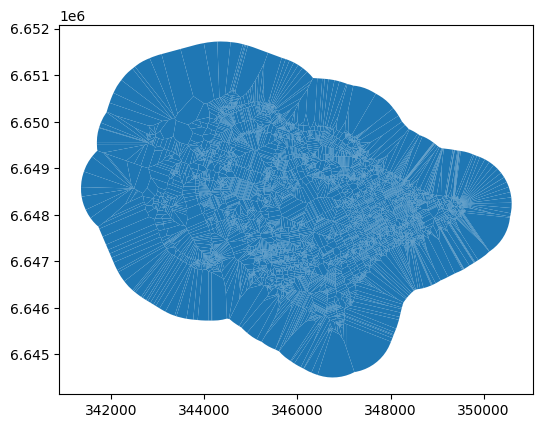

In [5]:
voronoi_gdf.plot()

## Grid

In [54]:
import pandas as pd

def get_grid(blocks_gdf : gpd.GeoDataFrame, voronoi_gdf : gpd.GeoDataFrame):
  blocks_gdf = blocks_gdf[['geometry']].copy()
  voronoi_gdf = voronoi_gdf[['geometry']].copy()
  for gdf in [blocks_gdf, voronoi_gdf]:
    gdf.geometry = gdf.geometry.apply(lambda g : shapely.LineString(g.exterior))
  lines_gdf = pd.concat([blocks_gdf, voronoi_gdf]).explode(ignore_index=True)
  lines = [line for line in lines_gdf.unary_union.geoms]
  geom_collection = shapely.polygonize(lines)
  return gpd.GeoDataFrame(geometry=list(geom_collection.geoms), crs=blocks_gdf.crs)

grid_gdf = get_grid(blocks_gdf, voronoi_gdf)
grid_gdf

,geometry
0,"POLYGON ((346701.362 6646318.927, 346693.422 6..."
1,"POLYGON ((346693.422 6646334.765, 346701.362 6..."
2,"POLYGON ((346693.422 6646334.765, 346685.483 6..."
3,"POLYGON ((346685.483 6646350.603, 346693.422 6..."
4,"POLYGON ((346681.231 6646357.408, 346676.980 6..."
...,...
16440,"POLYGON ((344010.325 6649243.877, 344022.010 6..."
16441,"POLYGON ((344022.010 6649278.050, 344033.067 6..."
16442,"POLYGON ((344033.067 6649310.386, 344042.128 6..."
16443,"POLYGON ((344051.170 6649334.193, 344060.211 6..."


<Axes: >

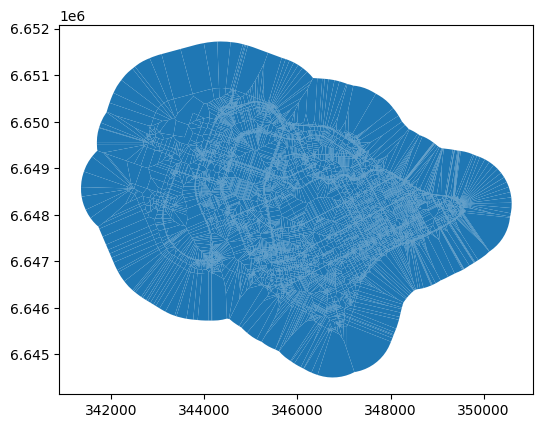

In [56]:
grid_gdf.plot()

In [63]:
blocks_gdf['block_index'] = blocks_gdf.index

In [114]:
from itertools import combinations

sjoin_gdf = blocks_gdf.sjoin(grid_gdf).groupby('index_right').agg({'block_index': lambda s : set(sorted(s))})
edges = {combination for s in sjoin_gdf.block_index for combination in combinations(s, 2)}
edges

{(12195, 12197),
 (8035, 8036),
 (3046, 3047),
 (3053, 2943),
 (9473, 12806),
 (6698, 6695),
 (3284, 215),
 (11657, 11655),
 (2951, 6687),
 (1240, 2316),
 (12193, 10323),
 (4712, 2613),
 (9469, 9510),
 (12937, 12812),
 (2721, 6755),
 (12801, 12802),
 (8130, 5685),
 (1140, 2085),
 (6600, 1140),
 (10320, 10319),
 (2584, 2585),
 (12843, 12804),
 (9472, 12818),
 (2585, 2586),
 (8130, 1111),
 (12700, 10397),
 (2315, 2316),
 (1320, 2582),
 (2661, 2315),
 (10643, 11359),
 (8462, 3506),
 (12812, 12938),
 (12512, 12268),
 (2418, 7634),
 (4892, 7926),
 (2824, 2723),
 (1160, 7898),
 (1240, 2823),
 (6956, 6679),
 (6697, 7242),
 (5548, 2983),
 (12191, 10231),
 (11700, 13148),
 (3019, 3020),
 (4892, 2943),
 (10320, 11994),
 (2355, 1319),
 (6624, 2943),
 (6698, 8262),
 (3052, 3053),
 (10392, 12922),
 (1345, 1276),
 (10489, 10231),
 (2276, 3506),
 (6601, 7017),
 (7240, 6595),
 (6955, 7923),
 (3053, 3054),
 (9930, 11701),
 (10907, 9468),
 (10740, 11655),
 (8632, 8631),
 (10904, 12023),
 (1297, 1729),
 

False

In [104]:
len(set(edges))

2279